<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#experiments" data-toc-modified-id="experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>experiments</a></span><ul class="toc-item"><li><span><a href="#random-grid-search" data-toc-modified-id="random-grid-search-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>random grid search</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# overview & motivation

As I'm just starting to learn about Remote Sensing in my master's degree and the first scientific papers my professor gave me to read were about water bodies detection on satellite images, I decided to try to implement a CNN for a analogous problem: water level detection on satellite images.


# setup

In [1]:
import datetime
import gc
import json
import os
import pprint
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [3]:
experiment_name = "newton_law_cooling"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# neural network architecture

In [4]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

# data

$$ \frac{dT}{dt} = k (T-S) $$ 

where $k<0$ is a constant. 

$$ T=(T_0-S) e^{kt} + S \qquad \qquad  $$

where $T_0$ is the initial temperature.

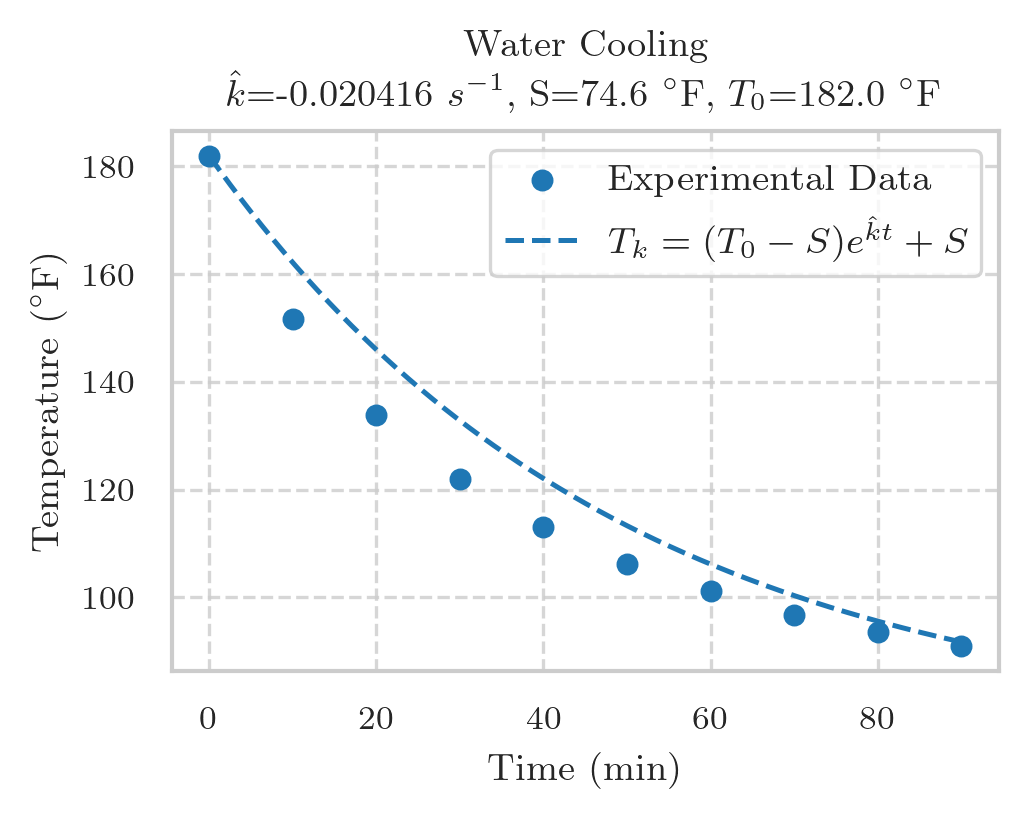

In [5]:
# raw data
data = [
    [0,	10,	20,	30,	40,	50,	60,	70,	80,	90],
    [182.0,	151.7,	133.9,	122.0,	113.1,	106.2,	101.1,	96.7,	93.5,	90.9],
]
X = pd.DataFrame(data).T.rename(columns={0: 'time', 1: 'temperature'}).astype({'time': int})
X.to_parquet(f"{folder_path}/experimental_data.parquet")

# physical parameters
S = 74.6
k = -0.020416
T_0 = X['temperature'][0]

# plot
fig, (ax1) = plt.subplots(ncols=1, nrows=1)

X.plot.scatter(x='time', y='temperature', ax=ax1, label="Experimental Data")

t = np.linspace(0, 90, 1000)
T = (T_0 - S) * np.exp(k * t) + S

ax1.plot(t, T, label="$T_k=(T_0-S) e^{\hat{k}t} + S$", linestyle='--') 
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Water Cooling \n $\hat{k}$=-0.020416 $s^{-1}$, S=74.6 $^\circ$F, $T_0$=182.0 $^\circ$F")

plt.legend()
plt.tight_layout()
plt.savefig(f"{folder_path}/plot_line_temperature_vs_time.png")

# experiments

In [6]:
folder_path = f"../data/08_reporting/{experiment_name}/random_grid_search"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

## random grid search

here only uniform multilayer perceptrons are considered.

In [7]:
def network_training(data, hyperparameters):
    """
    network_training
    """    
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

    _S = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    _T0 = torch.tensor(T_0, dtype=torch.float, requires_grad=False, device=device)
    _k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)

    x_train = torch.tensor(data["time"].values).float().unsqueeze(1).to(device)
    y_train = torch.tensor(data["temperature"].values).float().unsqueeze(1).to(device)

    hparam_dict = {
        'lambda_physics_loss' : hyperparameters['lambda_physics_loss'],
        'learning_rate': hyperparameters['learning_rate'],
        'n_layers': hyperparameters['n_layers'],
        'n_neurons': hyperparameters['n_neurons'],
        'num_epochs': hyperparameters['num_epochs'],
        'num_collocation_points': hyperparameters['num_collocation_points'],
        'activation': hyperparameters['activation'],
    }
    _architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]
    _collocation = torch.linspace(0, 90, hparam_dict["num_collocation_points"]).view(-1,1).requires_grad_(True).to(device)

    pprint.pprint(hparam_dict)

    model = MultiLayerPerceptronRegressor(_architecture, hparam_dict["activation"]).to(device)
    optimizer = optim.Adam(
        [
            {"params": model.parameters()}, 
            {"params": [_k]}
        ], 
        lr=hparam_dict["learning_rate"]
    )
    criterion = nn.MSELoss()

    plot_loss_train = dict(
        epoch=list(),
        dataloss=list(), 
        physicsloss=list(), 
        k=list()
    )
    for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        y_location_hat = model(_collocation)
        dydt = torch.autograd.grad(y_location_hat, _collocation, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

        _diff_equation = dydt - _k * (y_location_hat - _S)

        physics_loss = torch.mean(_diff_equation**2)
        _T0_loss = criterion(y_location_hat[0], _T0)

        loss = data_loss + hparam_dict["lambda_physics_loss"]*(physics_loss + _T0_loss)
        
        # backward
        loss.backward()
        optimizer.step()

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(physics_loss.item())
            plot_loss_train["k"].append(_k.item())
    
    gc.collect()

    _k_hat = _k.item()
    _mse = mean_squared_error(
        data['temperature'], 
        (T_0 - S) * np.exp(_k_hat * data['time']) + S
    )
    print(f"mse: {_mse:.4f}")
    print(f"k_hat: {_k_hat:.4f}")
    print()

    return pd.DataFrame(plot_loss_train), dict(k_hat=_k_hat, mse=_mse)

In [8]:
param_grid = {
    'lambda_physics_loss' : [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': [0.00001, 0.0001, 0.001, 0.1],
    'n_layers': [2, 3, 4, 5],
    'n_neurons': [8, 16, 32, 64, 128],
    'num_epochs': [100, 1000, 10000, 100000],
    'num_collocation_points': [10, 20, 30, 40, 50],
    'activation': [nn.Tanh, nn.ELU, nn.LeakyReLU, nn.ReLU]
}

In [9]:
np.random.seed(33)

for _index, _hparam in enumerate(np.random.choice(ParameterGrid(param_grid), 100, replace=False)):
    print(f"trial {_index+1}, {datetime.datetime.now()}")
    _history, _metrics = network_training(X.copy(), _hparam)

    folder_path = f"../data/08_reporting/{experiment_name}/random_grid_search/trial_{str(_index).zfill(3)}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    _hparam["activation"] = _hparam["activation"].__name__
    json.dump(_hparam, open(f"{folder_path}/hyperparameters.json", 'w'))
    json.dump(_metrics, open(f"{folder_path}/metrics.json", 'w'))
    _history.to_parquet(f"{folder_path}/history.parquet")

trial 1, 2023-11-05 18:13:50.694634
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.0001,
 'n_layers': 2,
 'n_neurons': 128,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 284.27it/s]


mse: 301679911249955175261117049920984926841694304336465446338501969566213603328.0000
k_hat: 0.9136

trial 2, 2023-11-05 18:13:55.373946
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.001,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:28<00:00, 350.65it/s]


mse: 16.5756
k_hat: -0.0260

trial 3, 2023-11-05 18:14:23.989043
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:30<00:00, 255.87it/s]


mse: 16.3992
k_hat: -0.0241

trial 4, 2023-11-05 18:20:54.935592
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 1e-05,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 361.65it/s]


mse: 285855729743430646714099320959997752003985026376161911908277316958776804874649600.0000
k_hat: 0.9900

trial 5, 2023-11-05 18:20:57.794987
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 250.99it/s]


mse: 5675440173414223075413362898852385134739456.0000
k_hat: 0.5077

trial 6, 2023-11-05 18:21:02.029948
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 10,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 262.36it/s]


mse: 4727.6910
k_hat: -0.0000

trial 7, 2023-11-05 18:21:05.940436
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.0001,
 'n_layers': 2,
 'n_neurons': 64,
 'num_collocation_points': 10,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 415.16it/s]


mse: 5131661438469231369748289737618779839843162163127743390585648787130591215616.0000
k_hat: 0.9293

trial 8, 2023-11-05 18:21:08.445037
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:37<00:00, 267.85it/s]


mse: 79219382204374956770594870181964914867711113671545359076682743166950965248.0000
k_hat: 0.9062

trial 9, 2023-11-05 18:21:45.878165
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:27<00:00, 258.22it/s]


mse: 18.9045
k_hat: -0.0267

trial 10, 2023-11-05 18:28:13.263424
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 64,
 'num_collocation_points': 50,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 298.00it/s]


mse: 320508974854068684478849527812632762300463436619899402158905978056984733037887488.0000
k_hat: 0.9907

trial 11, 2023-11-05 18:28:13.698884
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:36<00:00, 273.28it/s]


mse: 148.2785
k_hat: -0.0173

trial 12, 2023-11-05 18:28:50.397601
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 2,
 'n_neurons': 128,
 'num_collocation_points': 10,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:24<00:00, 404.73it/s]


mse: 59.2977
k_hat: -0.0202

trial 13, 2023-11-05 18:29:15.208330
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 1e-05,
 'n_layers': 2,
 'n_neurons': 64,
 'num_collocation_points': 30,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 624.00it/s]


mse: 1435094770021314696147471319480653512632458023324909741564498621700919525996756992.0000
k_hat: 0.9990

trial 14, 2023-11-05 18:29:15.461080
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 484.92it/s]


mse: 285589033995223032309411040219571693608233704175560049275374743668991062060302336.0000
k_hat: 0.9900

trial 15, 2023-11-05 18:29:15.765177
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.1,
 'n_layers': 5,
 'n_neurons': 32,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 363.63it/s]


mse: 179.4198
k_hat: -0.0166

trial 16, 2023-11-05 18:29:16.136780
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.0001,
 'n_layers': 5,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 358.31it/s]


mse: 284934082042242798126850272842976945568389123054612251601418218838658036784955392.0000
k_hat: 0.9900

trial 17, 2023-11-05 18:29:16.514524
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 471.34it/s]


mse: 288159000095926560382195777848930221299999867982375771733907979736408798946918400.0000
k_hat: 0.9901

trial 18, 2023-11-05 18:29:16.826620
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 64,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [04:31<00:00, 368.55it/s]


mse: 288.0676
k_hat: -0.0462

trial 19, 2023-11-05 18:33:48.266297
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 32,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [04:41<00:00, 355.11it/s]


mse: 4711.7298
k_hat: -0.0000

trial 20, 2023-11-05 18:38:29.976326
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:32<00:00, 301.12it/s]


mse: 54.7000
k_hat: -0.0204

trial 21, 2023-11-05 18:44:02.176573
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 128,
 'num_collocation_points': 50,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:56<00:00, 280.71it/s]


mse: 998.7157
k_hat: -0.0089

trial 22, 2023-11-05 18:49:58.517388
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 10,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 272.90it/s]


mse: 332620627866835470910416011270063194795109156624850575425536.0000
k_hat: 0.7222

trial 23, 2023-11-05 18:50:02.278981
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 1e-05,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 50,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [07:26<00:00, 223.93it/s]


mse: 1779077.3487
k_hat: 0.0374

trial 24, 2023-11-05 18:57:28.956213
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 264.23it/s]


mse: 5527706826131770054800961671457648148480.0000
k_hat: 0.4692

trial 25, 2023-11-05 18:57:32.836568
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 50,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:43<00:00, 227.38it/s]


mse: 25933697765793742848.0000
k_hat: 0.2091

trial 26, 2023-11-05 18:58:16.913484
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 243.46it/s]


mse: 1434617545594753416795718866298707913187994233486986403755967317529208846033092608.0000
k_hat: 0.9990

trial 27, 2023-11-05 18:58:17.420565
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:29<00:00, 303.23it/s]


mse: 213.0913
k_hat: -0.0160

trial 28, 2023-11-05 19:03:47.311266
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:37<00:00, 268.25it/s]


mse: 4727.7149
k_hat: 0.0000

trial 29, 2023-11-05 19:04:24.683369
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 30,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:38<00:00, 259.61it/s]


mse: 28933488441577164.0000
k_hat: 0.1712

trial 30, 2023-11-05 19:05:03.298353
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:47<00:00, 208.55it/s]


mse: 225460743070770063926495681535691616467603998604013145358308180889860973419552087883381944248095868520191771018060327660136634611775926352633580926097092777408502694908198529838335929292116425975842504507078196261335252143611219317620736.0000
k_hat: 2.9843

trial 31, 2023-11-05 19:05:51.345626
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 50,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 279.28it/s]


mse: 1434617545594753416795718866298707913187994233486986403755967317529208846033092608.0000
k_hat: 0.9990

trial 32, 2023-11-05 19:05:51.798740
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:37<00:00, 265.45it/s]


mse: 16.1719
k_hat: -0.0242

trial 33, 2023-11-05 19:06:29.566502
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 5,
 'n_neurons': 8,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 261.49it/s]


mse: 284924911156673487497638262797802946379925110176308227242066984408978435090677760.0000
k_hat: 0.9900

trial 34, 2023-11-05 19:06:30.039584
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [07:28<00:00, 222.94it/s]


mse: 4727.6910
k_hat: 0.0000

trial 35, 2023-11-05 19:13:58.691710
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.001,
 'n_layers': 3,
 'n_neurons': 32,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 291.23it/s]


mse: 3198852204669149400767195914877903402999085701115415772957973775792010690560.0000
k_hat: 0.9267

trial 36, 2023-11-05 19:13:59.134240
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.1,
 'n_layers': 5,
 'n_neurons': 128,
 'num_collocation_points': 50,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 202.24it/s]


mse: 486558.5669
k_hat: 0.0294

trial 37, 2023-11-05 19:13:59.725577
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:41<00:00, 292.56it/s]


mse: 20.5652
k_hat: -0.0232

trial 38, 2023-11-05 19:19:41.637234
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:25<00:00, 259.34it/s]


mse: 4727.6910
k_hat: -0.0000

trial 39, 2023-11-05 19:26:07.338320
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 32,
 'num_collocation_points': 30,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:27<00:00, 363.51it/s]


mse: 233207767954843200.0000
k_hat: 0.1829

trial 40, 2023-11-05 19:26:34.942017
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:04<00:00, 249.94it/s]


mse: 97962303017197442414585839616.0000
k_hat: 0.3317

trial 41, 2023-11-05 19:26:39.039532
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 10,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:34<00:00, 290.17it/s]


mse: 131.5890
k_hat: -0.0177

trial 42, 2023-11-05 19:27:13.593156
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 30,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:25<00:00, 259.71it/s]


mse: 3739567.1566
k_hat: 0.0418

trial 43, 2023-11-05 19:33:38.748112
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:37<00:00, 269.22it/s]


mse: 3363636034616820736.0000
k_hat: 0.1977

trial 44, 2023-11-05 19:34:15.984209
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 260.97it/s]


mse: 91419763295456331135734167982479433164600678535749114847530162918862618624.0000
k_hat: 0.9070

trial 45, 2023-11-05 19:34:16.456466
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 252.52it/s]


mse: 1241760558178403246279879566191325698949315177286456313743001164115504791552.0000
k_hat: 0.9214

trial 46, 2023-11-05 19:34:20.514642
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 128,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 364.44it/s]


mse: 6053032547382942760960.0000
k_hat: 0.2394

trial 47, 2023-11-05 19:34:20.883114
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [04:39<00:00, 357.47it/s]


mse: 17.7766
k_hat: -0.0237

trial 48, 2023-11-05 19:39:00.734836
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 32,
 'num_collocation_points': 40,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 472.80it/s]


mse: 269.6208
k_hat: -0.0150

trial 49, 2023-11-05 19:39:02.952882
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:25<00:00, 259.39it/s]


mse: 55.2812
k_hat: -0.0310

trial 50, 2023-11-05 19:45:28.574761
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 1e-05,
 'n_layers': 3,
 'n_neurons': 64,
 'num_collocation_points': 50,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 306.67it/s]


mse: 321921942453546953378051208716765249968528273910909322397693843883741560679956480.0000
k_hat: 0.9907

trial 51, 2023-11-05 19:45:31.931970
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 32,
 'num_collocation_points': 10,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 258.90it/s]


mse: 329.3010
k_hat: -0.0142

trial 52, 2023-11-05 19:45:35.891371
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 50,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:36<00:00, 252.52it/s]


mse: 16.7107
k_hat: -0.0261

trial 53, 2023-11-05 19:52:12.009489
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 250.59it/s]


mse: 4727.6910
k_hat: -0.0000

trial 54, 2023-11-05 19:52:16.096340
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.1,
 'n_layers': 5,
 'n_neurons': 8,
 'num_collocation_points': 50,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 208.62it/s]


mse: 22.6910
k_hat: -0.0229

trial 55, 2023-11-05 19:52:16.671484
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 64,
 'num_collocation_points': 10,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [07:03<00:00, 236.38it/s]


mse: 870.9505
k_hat: -0.0097

trial 56, 2023-11-05 19:59:19.818664
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 64,
 'num_collocation_points': 10,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:36<00:00, 277.04it/s]


mse: 33.1610
k_hat: -0.0218

trial 57, 2023-11-05 19:59:56.012471
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 30,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 260.86it/s]


mse: 46.9808
k_hat: -0.0303

trial 58, 2023-11-05 19:59:56.490885
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 1e-05,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:33<00:00, 294.58it/s]


mse: 91781421352704553248395206908831164745720133898013501876256121236242825216.0000
k_hat: 0.9070

trial 59, 2023-11-05 20:00:30.533550
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 1e-05,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 40,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 226.38it/s]


mse: 1434617545594753416795718866298707913187994233486986403755967317529208846033092608.0000
k_hat: 0.9990

trial 60, 2023-11-05 20:00:31.072448
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 30,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:31<00:00, 255.41it/s]


mse: 123507123.2704
k_hat: 0.0625

trial 61, 2023-11-05 20:07:02.714879
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 296.72it/s]


mse: 3092019893267081515247351801874566745726367668496819983341997214404286873600.0000
k_hat: 0.9265

trial 62, 2023-11-05 20:07:06.177371
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 64,
 'num_collocation_points': 30,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 423.83it/s]


mse: 996.7095
k_hat: -0.0090

trial 63, 2023-11-05 20:07:06.504235
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.001,
 'n_layers': 2,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:25<00:00, 385.20it/s]


mse: 31.1562
k_hat: -0.0220

trial 64, 2023-11-05 20:07:32.560915
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 1e-05,
 'n_layers': 3,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 485.35it/s]


mse: 1434617545594753416795718866298707913187994233486986403755967317529208846033092608.0000
k_hat: 0.9990

trial 65, 2023-11-05 20:07:32.861683
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 128,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 466.25it/s]


mse: 195543296918011277205961703424.0000
k_hat: 0.3355

trial 66, 2023-11-05 20:07:33.170630
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 64,
 'num_collocation_points': 10,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 327.98it/s]


mse: 135842375323746533084592366428147226221989726587176423904014705812941307904.0000
k_hat: 0.9092

trial 67, 2023-11-05 20:07:36.315549
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 8,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 276.26it/s]


mse: 1867544305576844959910034572784335073574912.0000
k_hat: 0.5016

trial 68, 2023-11-05 20:07:40.034162
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 5,
 'n_neurons': 64,
 'num_collocation_points': 50,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:41<00:00, 243.09it/s]


mse: 4727.6910
k_hat: -0.0000

trial 69, 2023-11-05 20:08:21.267773
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 8,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 248.48it/s]


mse: 44889514035362559600176353817082358974444083410010121989750922931588825088.0000
k_hat: 0.9030

trial 70, 2023-11-05 20:08:21.763549
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 32,
 'num_collocation_points': 10,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 270.06it/s]


mse: 4727.6910
k_hat: 0.0000

trial 71, 2023-11-05 20:08:25.569080
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.001,
 'n_layers': 3,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:22<00:00, 310.14it/s]


mse: 29.3712
k_hat: -0.0221

trial 72, 2023-11-05 20:13:48.115700
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 279.36it/s]


mse: 289066267294616074815101564010917402528334312459859706809135192108456435601375232.0000
k_hat: 0.9901

trial 73, 2023-11-05 20:13:48.571531
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:36<00:00, 272.92it/s]


mse: 4727.6910
k_hat: 0.0000

trial 74, 2023-11-05 20:14:25.314603
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 32,
 'num_collocation_points': 30,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:33<00:00, 254.28it/s]


mse: 30.6551
k_hat: -0.0220

trial 75, 2023-11-05 20:20:58.677779
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:34<00:00, 287.10it/s]


mse: 223792061037465156950434298345776567521094532909368468398121197932395506470466865876892050832690198129585890497457453255391098422858465608930015547848022761168510917594556441591238204677082473513844748931009087872829159257058638579311763534538054637039764241955554192853959704576.0000
k_hat: 3.5215

trial 76, 2023-11-05 20:21:33.611127
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 64,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 363.79it/s]


mse: 4537.6746
k_hat: -0.0003

trial 77, 2023-11-05 20:21:36.456118
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.0001,
 'n_layers': 5,
 'n_neurons': 32,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 287.11it/s]


mse: 286030596465132039460455482074291910906917288993784187510828331506261506027159552.0000
k_hat: 0.9900

trial 78, 2023-11-05 20:21:36.903712
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 32,
 'num_collocation_points': 30,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:59<00:00, 278.43it/s]


mse: 8667603.3631
k_hat: 0.0469

trial 79, 2023-11-05 20:27:36.169356
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.1,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 20,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 273.71it/s]


mse: 391.5279
k_hat: -0.0135

trial 80, 2023-11-05 20:27:36.638616
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 20,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:32<00:00, 305.32it/s]


mse: 2580087052078801.5000
k_hat: 0.1577

trial 81, 2023-11-05 20:28:09.491462
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 1e-05,
 'n_layers': 5,
 'n_neurons': 8,
 'num_collocation_points': 30,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 328.65it/s]


mse: 1434617545594753416795718866298707913187994233486986403755967317529208846033092608.0000
k_hat: 0.9990

trial 82, 2023-11-05 20:28:09.892712
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 621.90it/s]


mse: 44.2735
k_hat: -0.0210

trial 83, 2023-11-05 20:28:10.147187
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 8,
 'num_collocation_points': 20,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [05:31<00:00, 301.69it/s]


mse: 17.0589
k_hat: -0.0262

trial 84, 2023-11-05 20:33:41.725469
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 1e-05,
 'n_layers': 3,
 'n_neurons': 128,
 'num_collocation_points': 50,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:31<00:00, 318.74it/s]


mse: 69971524096341113307089315027879554200117205674628497044073063685868748800.0000
k_hat: 0.9055

trial 85, 2023-11-05 20:34:13.200558
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.001,
 'n_layers': 3,
 'n_neurons': 128,
 'num_collocation_points': 50,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 385.73it/s]


mse: 2496999953688910888960.0000
k_hat: 0.2345

trial 86, 2023-11-05 20:34:15.888004
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 1,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 128,
 'num_collocation_points': 50,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 300.53it/s]


mse: 1435464343116676483682698293390114707983971659228429015801435129120824249433456640.0000
k_hat: 0.9990

trial 87, 2023-11-05 20:34:16.333751
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 2,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 375.48it/s]


mse: 17138714615468953482014751622938865288899743836232125024221464716229197430784.0000
k_hat: 0.9360

trial 88, 2023-11-05 20:34:19.096966
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 0.0001,
 'n_layers': 2,
 'n_neurons': 8,
 'num_collocation_points': 40,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 348.19it/s]


mse: 287442638334718599116568846643433285833327813472150830959791170476363035451588608.0000
k_hat: 0.9901

trial 89, 2023-11-05 20:34:19.484178
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 447.71it/s]


mse: 289081774433502820517035046136494310703611815559518725235393313176388818954092544.0000
k_hat: 0.9901

trial 90, 2023-11-05 20:34:19.804992
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:08<00:00, 271.45it/s]


mse: 742.9041
k_hat: -0.0798

trial 91, 2023-11-05 20:40:28.307064
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 16,
 'num_collocation_points': 30,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 239.15it/s]


mse: 286977342672295365155587180846528818807886177939685534784123095079305500247982080.0000
k_hat: 0.9901

trial 92, 2023-11-05 20:40:28.822442
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.1,
 'n_layers': 2,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [04:27<00:00, 373.33it/s]


mse: 505.5875
k_hat: -0.0123

trial 93, 2023-11-05 20:44:56.803445
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 1e-05,
 'n_layers': 2,
 'n_neurons': 16,
 'num_collocation_points': 40,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:02<00:00, 345.02it/s]


mse: 289010448481984393786946569244911434458349225761089287497201182389796196350689280.0000
k_hat: 0.9901

trial 94, 2023-11-05 20:44:59.797101
{'activation': <class 'torch.nn.modules.activation.Tanh'>,
 'lambda_physics_loss': 1,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 8,
 'num_collocation_points': 50,
 'num_epochs': 10000}


100%|██████████| 10000/10000 [00:38<00:00, 260.15it/s]


mse: 4727.6992
k_hat: 0.0000

trial 95, 2023-11-05 20:45:38.335177
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 1e-05,
 'n_layers': 3,
 'n_neurons': 64,
 'num_collocation_points': 50,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 298.89it/s]


mse: 1436126732947305270064586113307735594133917615380860974127507529809997634687991808.0000
k_hat: 0.9990

trial 96, 2023-11-05 20:45:38.766533
{'activation': <class 'torch.nn.modules.activation.ELU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 325.96it/s]


mse: 238.1039
k_hat: -0.0155

trial 97, 2023-11-05 20:45:41.928570
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 1e-05,
 'n_layers': 4,
 'n_neurons': 32,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:03<00:00, 260.44it/s]


mse: 291852208790328319364100261659913588304633386491815765123994372482759172928045056.0000
k_hat: 0.9902

trial 98, 2023-11-05 20:45:45.864449
{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'lambda_physics_loss': 0.001,
 'learning_rate': 0.1,
 'n_layers': 3,
 'n_neurons': 16,
 'num_collocation_points': 10,
 'num_epochs': 100}


100%|██████████| 100/100 [00:00<00:00, 293.01it/s]


mse: 523.2392
k_hat: -0.0617

trial 99, 2023-11-05 20:45:46.302878
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.01,
 'learning_rate': 1e-05,
 'n_layers': 5,
 'n_neurons': 128,
 'num_collocation_points': 30,
 'num_epochs': 1000}


100%|██████████| 1000/1000 [00:04<00:00, 244.62it/s]


mse: 498848830315411991571006163295903243536610364232077386971139104979866240149356544.0000
k_hat: 0.9931

trial 100, 2023-11-05 20:45:50.486094
{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.1,
 'learning_rate': 0.001,
 'n_layers': 5,
 'n_neurons': 16,
 'num_collocation_points': 20,
 'num_epochs': 100000}


100%|██████████| 100000/100000 [06:44<00:00, 247.19it/s]


mse: 23.0719
k_hat: -0.0275



In [71]:
# display( pd.read_parquet(f"../data/08_reporting/{experiment_name}/random_grid_search/trial_000/history.parquet") )

# print(json.load(open(f"../data/08_reporting/{experiment_name}/random_grid_search/trial_000/hyperparameters.json", 'r')))

# print(json.load(open(f"../data/08_reporting/{experiment_name}/random_grid_search/trial_000/metrics.json", 'r')))

In [72]:
# fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10))

# pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss",  ax=ax1, label="Data Loss", linewidth=0.5)
# pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", ax=ax1, label="Physics Loss", linewidth=0.5)

# pd.DataFrame(plot_loss_train).plot(x="epoch", y="k", ax=ax2, label="k", linewidth=0.5)

# ax1.set_xlabel(r"Epoch")
# ax1.set_ylabel(r"Loss")
# ax1.set_title(r"Training Loss")
# ax1.set_yscale('log')
# ax1.legend()

# ax2.set_xlabel(r"Epoch")
# ax2.set_ylabel(r"k")
# ax2.set_title(r"Training Parameters")
# ax2.legend()

# plt.suptitle(r"$\alpha=10^{-3},\quad n_{\text{layers}}=4,\quad n_{\text{neurons}}=32,\quad n_{\text{epochs}}=50000, \quad \lambda=10^{-2}, \quad \text{activation}=\text{ELU}$")
# plt.tight_layout()
# plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

# pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
# pd.DataFrame(y_train.cpu().numpy(), columns=["temperature"]).to_parquet(f"{folder_path}/y_train.parquet")

# torch.save(model, f"{folder_path}/pinn_model.pth")
# torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

## results

In [73]:
# fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

# model.eval()

# with torch.no_grad():
#     X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

# X.query(f"time <= {train_test_threshold}").plot(
#     x="time", 
#     y="temperature", 
#     ax=ax1,
#     marker="x", c="g", linestyle="none", 
#     label=r"$\text{measurements (train)}$"
# )

# X.query(f"time > {train_test_threshold}").plot(
#     x="time", 
#     y="temperature", 
#     ax=ax1,
#     marker="x", c="r", linestyle="none", 
#     label=r"$\text{measurements (test)}$"
# )

# X.plot(
#     x="time", 
#     y="y_hat", 
#     ax=ax1,
#     c="b", linestyle="-", 
#     label=r"data prediction"
# ) 

# ax1.plot(
#     _locations.cpu().detach().numpy().reshape(-1, 1),
#     model(_locations).cpu().detach().numpy().reshape(-1)*0, 
#     c="r", linestyle="none", marker="o",
#     label=r"$\text{locations}$"
# )

# ax1.plot(
#     _locations.cpu().detach().numpy().reshape(-1, 1),
#     model(_locations).cpu().detach().numpy().reshape(-1), 
#     c="r", linestyle="--", marker=".",
#     label=r"$\text{locations prediction}$"
# ) 

# # ax1.set_xlabel("Time (min)")
# ax1.set_ylabel("Temperature ($^\circ$F)")
# ax1.set_title("Temperature vs Time")
# ax1.legend()


# X.plot.scatter(x='time', y='temperature', ax=ax2)
# t = np.linspace(0, 90, 1000)

# T = (X['temperature'][0] - S) * np.exp(k * t) + S
# _mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(k * X['time']) + S)
# ax2.plot(
#     t,
#     T, 
#     linestyle="--",
#     label=f"OLS fit: k={k:.6f}, MSE={_mse:.6f}",
# ) 

# _mse = mean_squared_error(X['temperature'], (X['temperature'][0] - S) * np.exp(_k.item() * X['time']) + S)
# T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S
# ax2.plot(
#     t,
#     T, 
#     linestyle="--",
#     label=f"PINN fit: k={_k.item():.6f}, MSE={_mse:.6f}",
# ) 

# ax2.set_xlabel("Time (min)")
# ax2.set_ylabel("Temperature ($^\circ$F)")
# ax2.legend()

# plt.tight_layout()

# plt.savefig(f"{folder_path}/temperature_vs_time_with_prediction.png", dpi=300)

.